Unsupervised Learning - Clustering algorithms

# In Depth: Gaussian Mixture Models

The k-means clustering model explored in the previous section is simple and relatively easy to understand, but its simplicity leads to partical challenges in its application. In particular, the nonprobabilistic nature of k-means and its use of simple distance-from-cluster-center to assign cluster membership leads to poor performance for many real-world situations. In this section we will take a look at Gaussian mixture models, which can be viewed as an extension of the ideas behind k-means, but can also be a powerful tool for estimation beyond simple clustering. We begin with the standard imports:

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

## Motivating GMM: Weakness of k-Means

Let's take a look at some of the weaknesses of k-means and think about how we might improve the cluster model. As we saw in the previous section, given simple, well-separated data, k-means finds suitable clustering results.

For example, if we have simple blobs of data, the k-means algorithm can quickly label those clusters in a way that closely matches what we might do by eye:

In [2]:
# Generate some data
from sklearn.datasets.samples_generator import make_blobs
X, y_true = make_blobs(n_samples=400, centers=4,
                       cluster_std=0.60, random_state=0)
X = X[:, ::-1] # flip axes for better plotting

C:\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.datasets.samples_generator module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


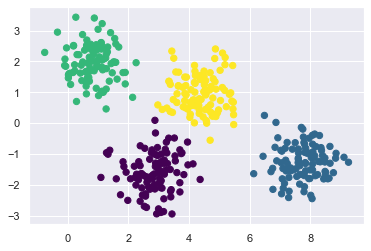

In [3]:
# Plot the data with K Means Labels
from sklearn.cluster import KMeans
kmeans = KMeans(4, random_state=0)
labels = kmeans.fit(X).predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis');

From an intuitive standpoint, we might, expect that the clustering assignment for some points is more certain than others; for example, there appears to be a very slight overlap between the two middle clusters, such that we might not have complete confidence in the cluster assignment of points between them. Unfortunately, the k-means model has no intrinsic measure of probability or uncertainty of cluster assignments (although it may be possible to use a bootstrap approach to estimate this uncertainty). For this, we must think about generalizing the model.

One way to think about the k-means model is that it places a circle (or, in higher dimensions, a hyper-sphere) at the center of each lcuster, with a radius defined by the most distant point in the cluster. Thsi radius acts as a hard cutoff for cluster assignment within the training set: any point outside this circle is not considered a memebr of te cluster. We can visualize this cluster model with the following function:

In [4]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

def plot_kmeans(kmeans, X, n_clusters=4, rseed=0, ax=None):
    labels = kmeans.fit_predict(X)

    # plot the input data
    ax = ax or plt.gca()
    ax.axis('equal')
    ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)

    # plot the representation of the KMeans model
    centers = kmeans.cluster_centers_
    radii = [cdist(X[labels == i], [center]).max()
             for i, center in enumerate(centers)]
    for c, r in zip(centers, radii):
        ax.add_patch(plt.Circle(c, r, fc='#CCCCCC', lw=3, alpha=0.5, zorder=1))

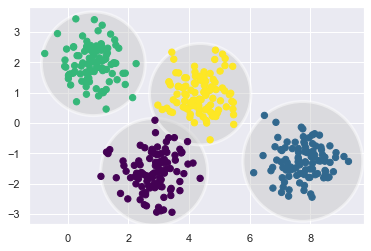

In [5]:
kmeans = KMeans(n_clusters=4, random_state=0)
plot_kmeans(kmeans, X)

An important observation for k-means is that these cluster models **must be circular**: k-means has no built-in way of accounting for oblong or elliptical clusters. So, for example, if we take the same data and transform it, the cluster assignments end up becoming muddled:

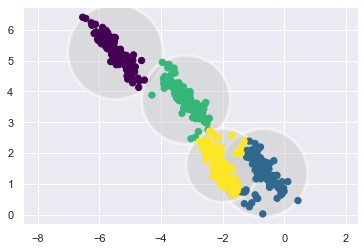

In [6]:
rng = np.random.RandomState(13)
X_stretched = np.dot(X, rng.randn(2, 2))

kmeans = KMeans(n_clusters=4, random_state=0)
plot_kmeans(kmeans, X_stretched)

By eye, we recognize that these transformed clusters are noncircular, and thus circular clusters would be a poor fit. Nevertheless, **k-means** is not flexible enough to account for this, and tries to force-fit the data into four circular clusters. This results in a mixing of cluster assignments where the resulting cicle overlap: see especially the bottom right of this plot. One might imagine addressing this particular situation by preprocessing the data with PCA, but in practice there is no guararntee that such a global operation will circularize the individual data.

These two disadvantages of **k-means** - its lack of flexibility in cluster shape and lack of probabilistic cluster assignment - mean that for many datasets (especially low-dimensional datasets) it may not perform as well as you might hope.

You might image addressing these weaknesses by generalizing the **k-means** model: for example, you could measure uncertainty in cluster assignment by comparing the distance of each point to **all** cluster centers, rather than focusing on just the closest. You might also image allowing the cluster boundaries to be ellipses rather than circles, so as to account for noncircular clusters. It turns out these are two essential components of a different type of clustering model, **Gaussian mixture models**.

## Generalizing E-M: Gaussian Mixture Models

A Gaussian mixture model (GMM) attempts to find a mixture of multidimensional Gaussian probability distributions that best model any input datset. In the simplest case, GMMs can be used for finding clusters in the same manner as k-means:

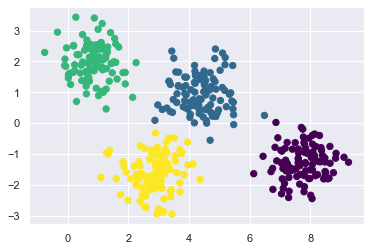

In [7]:
from sklearn import mixture # old code: from sklearn.mixture import GMM
gmm = mixture.GaussianMixture(n_components=4).fit(X)
labels = gmm.predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis');

But because GMM contains a probabilistic model under the hood, it is also possible to find probabilistic cluster assignments - in Scikit-Learn we do this using the `predict_proba` method. This returns a matreix of size `[n_samples, n_clusters]` that measures the probability that any point belongs to the given cluster:

In [9]:
probs = gmm.predict_proba(X)
print(probs[:5].round(3))

[[0.469 0.531 0.    0.   ]
 [0.    0.    0.    1.   ]
 [0.    0.    0.    1.   ]
 [0.    1.    0.    0.   ]
 [0.    0.    0.    1.   ]]


We can visualize this uncertainty by, for example, making the size of each point proportional to the certainty of its prediction; looking at the following figure, we can see that it is precisely the points at the boundaries between clusters that refelct this uncertainnty of cluster assignment:

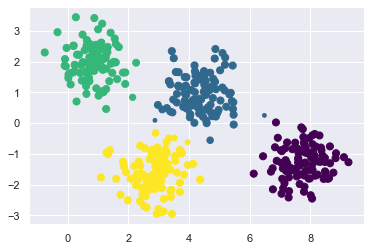

In [10]:
size = 50 * probs.max(1) ** 2  # square emphasizes differences
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=size);

## GMM as Density Estimation

## Example: GMM for Generating New Data